In [1]:
from __future__ import print_function, division
import os
import shutil
import re

from PIL import Image, ImageFile

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from PIL import Image
import torchvision

from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy

from torch.utils.data import Dataset, DataLoader

ImageFile.LOAD_TRUNCATED_IMAGES = True


In [50]:
# Applying Transforms to the Data
image_transforms = { 
    'train': transforms.Compose([
        
        transforms.RandomResizedCrop(size=224),
        transforms.Resize(size=(256,256)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(), 
        transforms.Grayscale(3),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406],  #Local Normalization  Standardization (Z-score Normalization)  
         #                    [0.229, 0.224, 0.225])  
        # Standardization #(T – mean)/(standard deviation) 
#     In machine learning, we can handle various types of data, e.g. audio signals and pixel values 
#    for image data, and this data can include multiple dimensions. Feature standardization makes 
#       the values of each feature in the data have zero-mean (when subtracting the mean in the numerator) 
#      and unit-variance. This method is widely used for normalization in many machine learning algorithms 
#      (e.g., support vector machines, logistic regression, and artificial neural networks)[2][citation needed]. 
#      The general method of calculation is to determine the distribution mean and standard deviation for each
#   feature. Next we subtract the mean from each feature. Then we divide the values (mean is already subtracted) 
#     of each feature by its standard deviation."""
      
        
        
        
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=(256,256)),
        transforms.CenterCrop(size=224),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406],
        #                    [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
      transforms.Resize(size=(256,256)),
        transforms.CenterCrop(size=224),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406],
        #                     [0.229, 0.224, 0.225])
    ])
}

In [51]:
# Load the Data
 
# Set train and valid directory paths
train_directory = r"C:\data\train"
valid_directory = r"C:\data\val"
test_directory = r"C:\data\test"
# Batch size
bs = 32
 
# Number of classes
num_classes = 4
 
# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}


In [52]:
# Create iterators for the Data loaded using DataLoader module
train_data_loader  = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader  = DataLoader(data['valid'], batch_size=bs, shuffle=True)
test_data_loader  = DataLoader(data['test'], batch_size=bs, shuffle=True)
 


In [53]:
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

{0: 'certificate', 1: 'other', 2: 'resume', 3: 'transcript'}


In [54]:
#Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])
# Print the train, validation and test set data sizes
train_data_size, valid_data_size, test_data_size

(1251, 155, 160)

In [7]:
# Load pretrained ResNet50 Model
resnext101_32x8d = models.resnext101_32x8d(pretrained=True)
resnext101_32x8d = resnext101_32x8d.to('cuda:0')

In [8]:
# Freeze model parameters
#we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().
for param in resnext101_32x8d.parameters():
    param.requires_grad = False

In [9]:
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnext101_32x8d.fc.in_features

resnext101_32x8d.fc = nn.Sequential(

    
    nn.Linear(fc_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.25),

    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.25),
    
    nn.Linear(256, 512),
    nn.ReLU(),
    nn.Dropout(0.25),


    

    nn.Linear(512, num_classes), # Since 4possible outputs
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

In [10]:
# Convert model to be used on GPU
resnext101_32x8d = resnext101_32x8d.to('cuda:0')

In [11]:
# Define Optimizer and Loss Function
loss_func = nn.NLLLoss()
optimizer = optim.Adam(resnext101_32x8d.parameters(), lr=0.0001)

In [12]:
#from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from io import BytesIO

In [13]:

def train_and_validate(model, loss_criterion, optimizer, epochs):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
      
        
        
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))
            

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            #model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size  #running_loss
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
        

        
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        


        
        # Save if the model has best accuracy till now
        #torch.save(model, r"C:\\Users\\BiePo\\Desktop\\project_overall\\save_model\\_model_"+str(epoch)+".pt")
        torch.save(model, r"E:\model\model_"+str(epoch+1)+".pt")    

    
    return model, history


In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



# Train the model for 300 epochs
num_epochs = 300
trained_model, history = train_and_validate(resnext101_32x8d, loss_func, optimizer, num_epochs)

Epoch: 1/300


C:\Users\BiePo\.conda\envs\myproject\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch : 000, Training: Loss: 1.3078, Accuracy: 40.4476%, 
		Validation : Loss : 1.2750, Accuracy: 40.6452%, Time: 74.9704s
Epoch: 2/300
Epoch : 001, Training: Loss: 1.2034, Accuracy: 45.7234%, 
		Validation : Loss : 1.1037, Accuracy: 58.7097%, Time: 75.9187s
Epoch: 3/300
Epoch : 002, Training: Loss: 0.9784, Accuracy: 61.8705%, 
		Validation : Loss : 0.8243, Accuracy: 72.2581%, Time: 72.4175s
Epoch: 4/300
Epoch : 003, Training: Loss: 0.8283, Accuracy: 66.9065%, 
		Validation : Loss : 0.6537, Accuracy: 76.1290%, Time: 73.0707s
Epoch: 5/300
Epoch : 004, Training: Loss: 0.7058, Accuracy: 73.4612%, 
		Validation : Loss : 0.5753, Accuracy: 79.3548%, Time: 72.1932s
Epoch: 6/300
Epoch : 005, Training: Loss: 0.6694, Accuracy: 74.9001%, 
		Validation : Loss : 0.5471, Accuracy: 81.9355%, Time: 71.3507s
Epoch: 7/300
Epoch : 006, Training: Loss: 0.6507, Accuracy: 76.4189%, 
		Validation : Loss : 0.4618, Accuracy: 84.5161%, Time: 74.9672s
Epoch: 8/300
Epoch : 007, Training: Loss: 0.5960, Accuracy: 7

In [15]:
import numpy 

In [16]:
history = np.array(history)

In [17]:
print("mean accuracy",history[:,3:4].mean())
print("max accuracy",history[:,3:4].max())
print("mean loss",history[:,1:2].mean())
print("min loss",history[:,1:2].min())

mean accuracy 0.8780000010882655
max accuracy 0.9483870940823709
mean loss 0.3154133671784112
min loss 0.1727730779878555


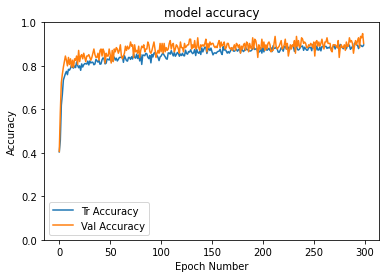

In [18]:
history = np.array(history)


plt.plot(history[:,2:4])
plt.title('model accuracy')
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
#plt.savefig("C:\\Users\\BiePo\\Desktop\\accuracy_curve.png")
plt.show()

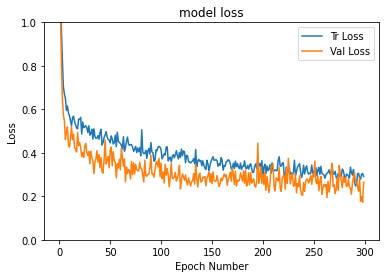

In [19]:

plt.title("model loss")
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
#plt.savefig(r"C:\Users\BiePo\Desktop\64_128_256"+"_loss_curve.png")
plt.show()


In [62]:
def predict(model, test_image_name):
     
    transform = image_transforms['test']
 
    test_image = Image.open(test_image_name)
    #plt.imshow(test_image)
     
    test_image_tensor = transform(test_image)
 
    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
     
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(1, dim=1)
        print("Output class :  ", idx_to_class[topclass.cpu().numpy()[0][0]])
        y_predict.append(idx_to_class[topclass.cpu().numpy()[0][0]])

In [63]:
def getListOfFiles(dirName):
        
        dirName = dirName
        listOfFile = os.listdir(dirName)
        allFiles = list()

        for entry in listOfFile:
            fullPath = os.path.join(dirName, entry)
            if os.path.isdir(fullPath):
                allFiles = allFiles + getListOfFiles(fullPath)
            else:
                allFiles.append(fullPath)

        return allFiles

In [64]:
indexofmaxacc=np.argmax(history[:,3:4])
indexofmaxacc

298

In [65]:
testpath = getListOfFiles(r"C:\data\test")

In [66]:
i=0
y_true=[]
for i in range(len(testpath)):
    y_true.append(os.path.basename(os.path.dirname(testpath[i])))


In [67]:

# Test a particular model on a test image
y_predict = []

model = torch.load(r"E:\model\model_"+ str(indexofmaxacc)  +".pt")

i=0
for i in range(len(testpath)):
    print(testpath[i])
    predict(model, testpath[i])
    print()

# Load Data from folders
#computeTestSetAccuracy(model, r"C:\Users\BiePo\Desktop\test set")  

C:\data\test\certificate\10.png
Output class :   certificate

C:\data\test\certificate\107 (2)_2.jpg
Output class :   certificate

C:\data\test\certificate\116.jpg
Output class :   certificate

C:\data\test\certificate\119.jpg
Output class :   certificate

C:\data\test\certificate\120.jpg
Output class :   certificate

C:\data\test\certificate\152.jpg
Output class :   certificate

C:\data\test\certificate\159 (4).jpg
Output class :   resume

C:\data\test\certificate\169.jpg
Output class :   certificate

C:\data\test\certificate\185 (2).jpg
Output class :   certificate

C:\data\test\certificate\213.png
Output class :   resume

C:\data\test\certificate\221 (3).jpg
Output class :   certificate

C:\data\test\certificate\240.jpg
Output class :   certificate

C:\data\test\certificate\249 (2).jpg
Output class :   certificate

C:\data\test\certificate\25.jpg
Output class :   certificate

C:\data\test\certificate\28 (3).jpg
Output class :   certificate

C:\data\test\certificate\35.jpg
Output cla

In [68]:
classdoc = []
for key in idx_to_class.keys():
    classdoc.append(idx_to_class[key]) 
classdoc

['certificate', 'other', 'resume', 'transcript']

In [70]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_predict,target_names=classdoc))

              precision    recall  f1-score   support

 certificate       0.91      0.94      0.92        32
       other       0.94      0.76      0.84        66
      resume       0.74      0.90      0.81        31
  transcript       0.86      1.00      0.93        31

    accuracy                           0.87       160
   macro avg       0.86      0.90      0.88       160
weighted avg       0.88      0.87      0.87       160



In [72]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
conf = confusion_matrix(y_true, y_predict)
conf

array([[30,  0,  2,  0],
       [ 3, 50,  8,  5],
       [ 0,  3, 28,  0],
       [ 0,  0,  0, 31]], dtype=int64)

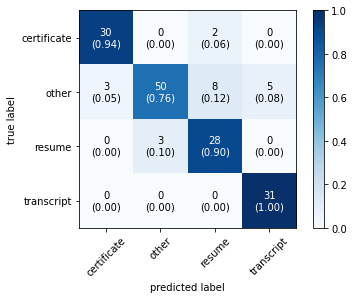

In [73]:
fig, ax = plot_confusion_matrix(conf_mat=conf,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True,
                                class_names=classdoc)
plt.show()